# Hotspots Prediction for US Cities

In [1]:
import torch

# Use CUDA by default
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [2]:
import numpy as np
import random

DEFAULT_SEED = 42

def set_seed(seed=DEFAULT_SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [3]:
from collections import Counter
from torch.nn.functional import softmax
from torch_geometric.utils import index_to_mask
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path


def load_dataset(filename: str):
    if not Path(f"../data/TAP-city/{filename}.npz").is_file():
        return None, None

    data_npz = np.load(f"../data/TAP-city/{filename}.npz", allow_pickle=True)
    
    # Extract node features: use only the first two columns
    x_raw = data_npz["x"][:, :2]  # assuming 0 = highway (categorical), 1 = street_count
    x_raw_tensor = torch.tensor(x_raw, dtype=torch.float)
    
    # Extract and average edge features
    edge_attr_raw = data_npz["edge_attr"][:, :9]  # only first 9 raw edge features
    edge_attr_dir = data_npz["edge_attr_dir"]     # (x, y)
    edge_attr_ang = data_npz["edge_attr_ang"]     # (min, max, pi)
    
    # Concatenate raw edge features
    full_edge_attr = np.concatenate([edge_attr_raw, edge_attr_dir, edge_attr_ang], axis=1)
    
    # Map edge features to nodes (average)
    edge_index = data_npz["edge_index"]
    node_feature_map = defaultdict(list)
    
    for i, (src, tgt) in enumerate(edge_index):
        node_feature_map[src].append(full_edge_attr[i])
        node_feature_map[tgt].append(full_edge_attr[i])
    
    edge_features_per_node = np.array([
        np.mean(node_feature_map[i], axis=0) if i in node_feature_map else np.zeros(full_edge_attr.shape[1])
        for i in range(x_raw.shape[0])
    ])
    
    # Concatenate node + aggregated edge features
    x_final = np.concatenate([x_raw, edge_features_per_node], axis=1)
    x_final_tensor = torch.tensor(x_final, dtype=torch.float)
    
    # Labels and edge_index
    y = torch.tensor(data_npz["occur_labels"], dtype=torch.long)
    edge_index_tensor = torch.tensor(data_npz["edge_index"].T, dtype=torch.long)
    
    # Final PyG graph
    data = Data(x=x_final_tensor, y=y, edge_index=edge_index_tensor)
    
    # Split into train/val/test
    all_idx = torch.arange(data.num_nodes)
    train_idx, test_idx = train_test_split(all_idx, test_size=0.2, stratify=y, random_state=DEFAULT_SEED)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, stratify=y[train_idx], random_state=DEFAULT_SEED)
    
    data.train_mask = index_to_mask(train_idx, size=data.num_nodes)
    data.val_mask = index_to_mask(val_idx, size=data.num_nodes)
    data.test_mask = index_to_mask(test_idx, size=data.num_nodes)
    return data, data_npz

In [4]:
import os

def fetch_cities() -> dict[str, str]:
    cities = {}
    for file in os.listdir("../data/TAP-city"):
        cities[file.split(".")[0]] = file.split(".")[0]
    return cities

In [5]:
import torch
from torch_geometric.nn import GATConv, SAGEConv, ChebConv, GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x
    
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, aggr="softmax", dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=aggr)
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr=aggr)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
class ChebNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, K=3, dropout=0.5):
        super().__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, out_channels, K=K)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [6]:
model_configs = {
    "GCN": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2},
        "lr": 0.05,
        "epochs": 100
    },
    "GAT": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 2},
        "lr": 0.05,
        "epochs": 100
    },
    "GraphSAGE": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "softmax"},
        "lr": 0.1,
        "epochs": 100
    },
    "ChebNet": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 3},
        "lr": 0.05,
        "epochs": 100
    }
}

In [7]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        return correct / mask.sum().item()

In [8]:
def train_model(name, config, data, patience=20):
    model = config["class"](in_channels=data.x.shape[1], **config["params"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    
    val_accs = []
    losses = []

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["epochs"]):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        val_acc = evaluate(model, data, data.val_mask)
        val_accs.append(val_acc)

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and config.get("early_stopping", True):
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    test_acc = evaluate(model, data, data.test_mask)
    print(f"{name} Best Val Acc: {best_val_acc:.4f} | Test Acc: {test_acc:.4f}")

    return model, losses, val_accs, test_acc

In [9]:
all_cities = fetch_cities()

la_data, la_data_npz = load_dataset(all_cities["los_angeles_ca"])

print([key for key in la_data_npz.keys()])


['x', 'occur_labels', 'edge_attr', 'edge_index', 'edge_attr_dir', 'edge_attr_ang', 'coordinates', 'severity_8labels', 'severity_5labels', 'severity_raw', 'cnt_labels', 'crash_time']


In [10]:
trained_models = {}
results = {}

set_seed(42)
for model_name, cfg in model_configs.items():
    print(f"\nTraining {model_name}")
    model, losses, accs, test_accs = train_model(model_name, cfg, la_data) 
    trained_models[model_name] = model                        
    results[model_name] = {"loss": losses, "acc": accs}


Training GCN
Early stopping at epoch 31
GCN Best Val Acc: 0.8811 | Test Acc: 0.8699

Training GAT
Early stopping at epoch 38
GAT Best Val Acc: 0.8814 | Test Acc: 0.8721

Training GraphSAGE
Early stopping at epoch 33
GraphSAGE Best Val Acc: 0.8705 | Test Acc: 0.8699

Training ChebNet
Early stopping at epoch 33
ChebNet Best Val Acc: 0.8774 | Test Acc: 0.8750


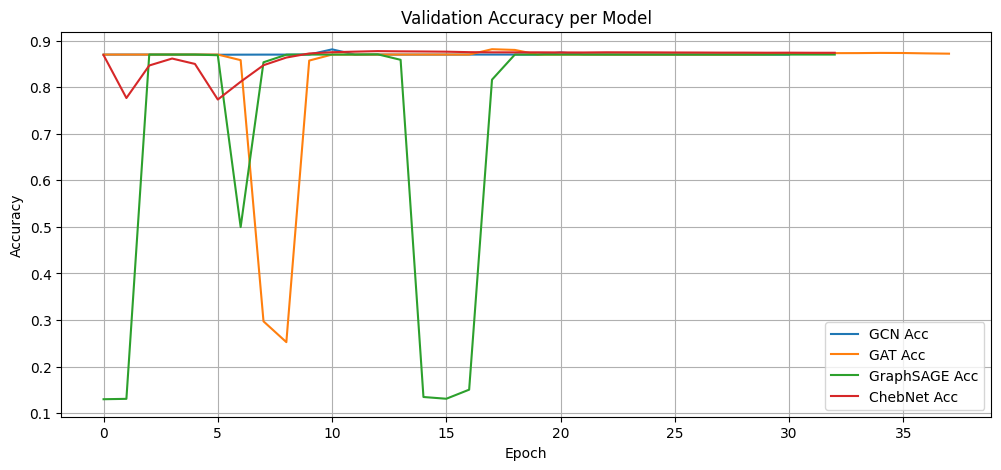

In [11]:
plt.figure(figsize=(12, 5))

# Accuracy
for name, res in results.items():
    plt.plot(res["acc"], label=f"{name} Acc")
plt.title("Validation Accuracy per Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
tuned_model_configs = {
    "GCN": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2, "dropout": 0.5},
        "lr": 0.001,
        "epochs": 100
    },
    "GAT": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 8, "dropout": 0.5},
        "lr": 0.001,
        "epochs": 100
    },
    "GraphSAGE": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "mean", "dropout": 0.5},
        "lr": 0.001,
        "epochs": 100
    },
    "ChebNet": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 2, "dropout": 0.5},
        "lr": 0.001,
        "epochs": 100
    }
}

In [20]:
def training_run(cfgs):
    trained_models = {}
    results = {}

    set_seed(42)
    for model_name, cfg in cfgs.items():
        print(f"\nTraining {model_name}")
        model, losses, accs, test_accs = train_model(model_name, cfg, la_data) 
        trained_models[model_name] = model                        
        results[model_name] = {"loss": losses, "acc": accs}

    plt.figure(figsize=(12, 5))

    # Accuracy
    for name, res in results.items():
        plt.plot(res["acc"], label=f"{name} Acc")
    plt.title("Validation Accuracy per Model")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    #Loss
    plt.figure(figsize=(12, 5))
    for name, res in results.items():
        plt.plot(res["loss"], label=f"{name} Loss")
    plt.title("Training Loss per Model")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Training GCN
Early stopping at epoch 21
GCN Best Val Acc: 0.8699 | Test Acc: 0.8699

Training GAT
Early stopping at epoch 27
GAT Best Val Acc: 0.8699 | Test Acc: 0.8699

Training GraphSAGE
Early stopping at epoch 30
GraphSAGE Best Val Acc: 0.8699 | Test Acc: 0.8694

Training ChebNet
Early stopping at epoch 80
ChebNet Best Val Acc: 0.8699 | Test Acc: 0.8699


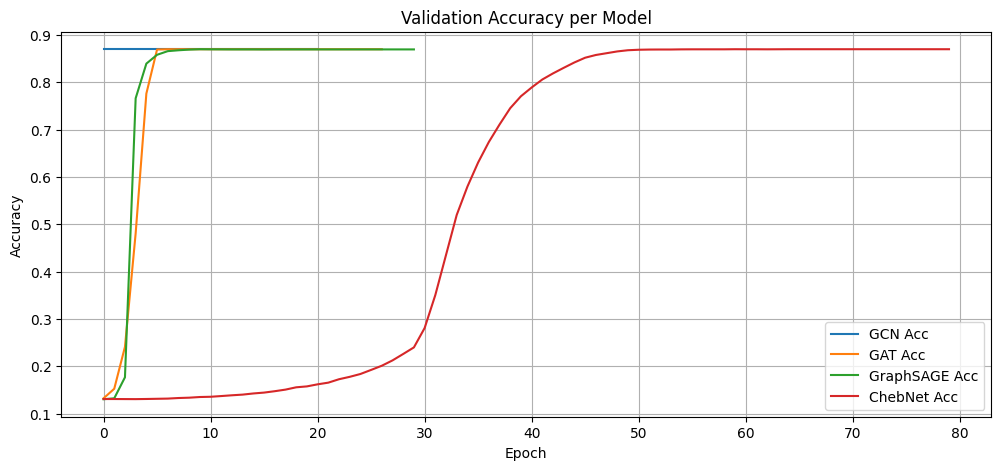

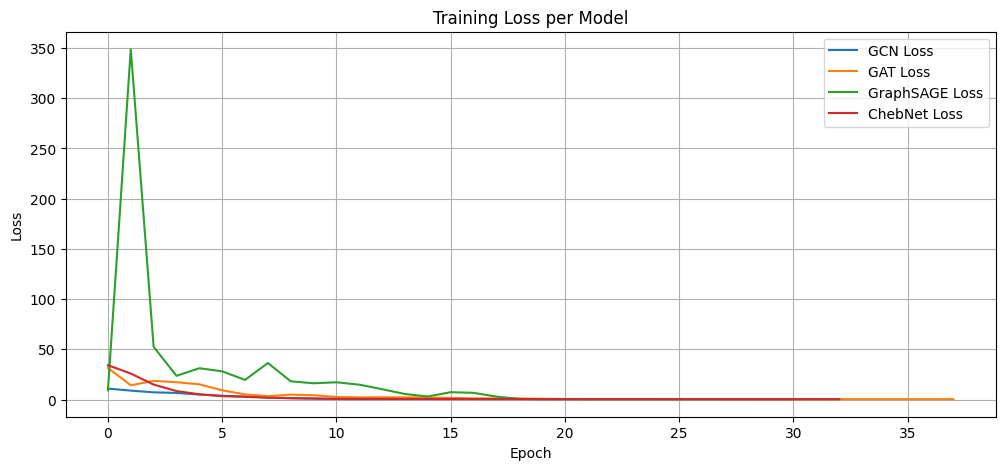

In [13]:
tuned_trained_models = {}
tuned_results = {}

set_seed(42)
for model_name, cfg in tuned_model_configs.items():
    print(f"\nTraining {model_name}")
    model, losses, accs, test_accs = train_model(model_name, cfg, la_data) 
    tuned_trained_models[model_name] = model                        
    tuned_results[model_name] = {"loss": losses, "acc": accs}

plt.figure(figsize=(12, 5))

# Accuracy
for name, res in tuned_results.items():
    plt.plot(res["acc"], label=f"{name} Acc")
plt.title("Validation Accuracy per Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Loss
plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res["loss"], label=f"{name} Loss")
plt.title("Training Loss per Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Training GCN_1
GCN_1 Best Val Acc: 0.8822 | Test Acc: 0.8837

Training GCN_2
Early stopping at epoch 21
GCN_2 Best Val Acc: 0.8699 | Test Acc: 0.8699

Training GCN_3
Early stopping at epoch 52
GCN_3 Best Val Acc: 0.8903 | Test Acc: 0.8746

Training GCN_4
Early stopping at epoch 21
GCN_4 Best Val Acc: 0.8699 | Test Acc: 0.8699

Training GCN_5
Early stopping at epoch 21
GCN_5 Best Val Acc: 0.8699 | Test Acc: 0.8610


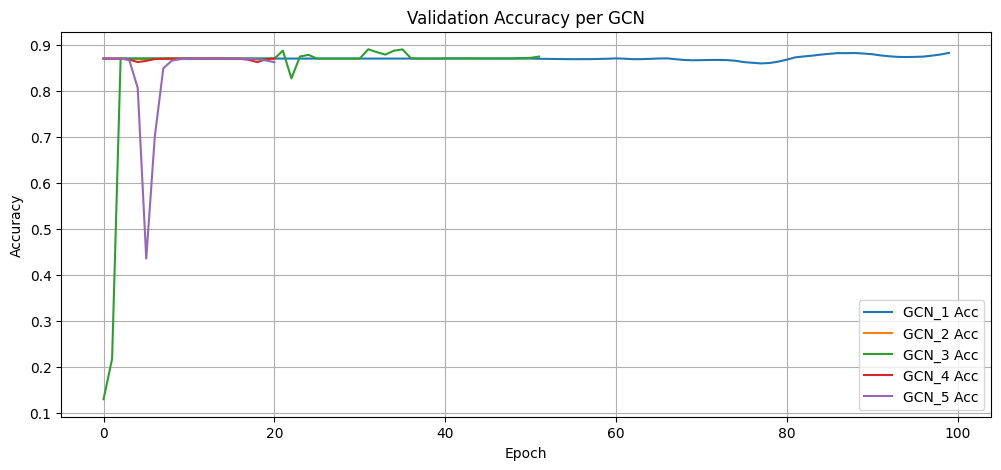

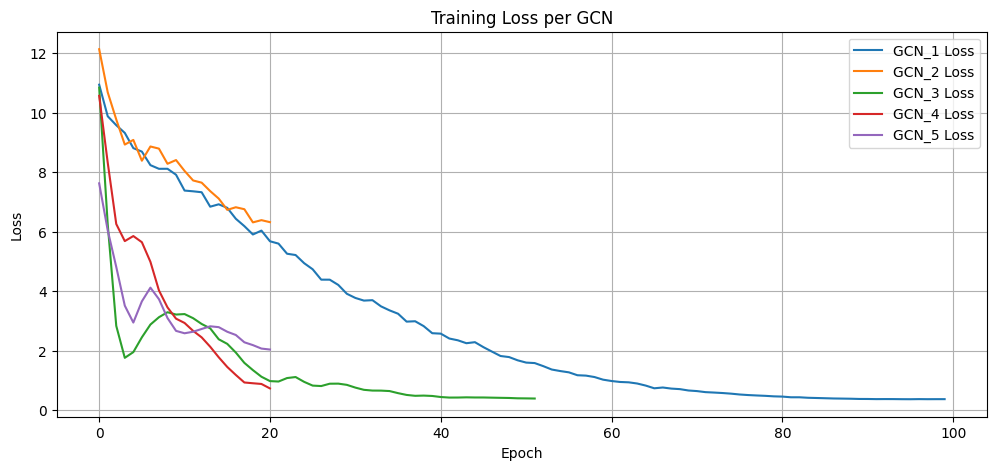

In [15]:
gcn_models_configs = {
    "GCN_1": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2, "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100,
        "early_stopping": False
    },
    "GCN_2": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2, "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100,
        "early_stopping": True
    },
    "GCN_3": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2, "dropout": 0.5},
        "lr": 0.01,
        "epochs": 100
    },
    "GCN_4": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2, "dropout": 0.5},
        "lr": 0.02,
        "epochs": 100
    },
    "GCN_5": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2, "dropout": 0.3},
        "lr": 0.01,
        "epochs": 100
    },
}

gcn_models = {}
gcn_results = {}

set_seed(42)
for model_name, cfg in gcn_models_configs.items():
    print(f"\nTraining {model_name}")
    model, losses, accs, test_accs = train_model(model_name, cfg, la_data) 
    gcn_models[model_name] = model                        
    gcn_results[model_name] = {"loss": losses, "acc": accs}

plt.figure(figsize=(12, 5))

# Accuracy
for name, res in gcn_results.items():
    plt.plot(res["acc"], label=f"{name} Acc")
plt.title("Validation Accuracy per GCN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Loss
plt.figure(figsize=(12, 5))
for name, res in gcn_results.items():
    plt.plot(res["loss"], label=f"{name} Loss")
plt.title("Training Loss per GCN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Training GAT_1
GAT_1 Best Val Acc: 0.8863 | Test Acc: 0.8875

Training GAT_2
GAT_2 Best Val Acc: 0.8888 | Test Acc: 0.8871

Training GAT_3
Early stopping at epoch 54
GAT_3 Best Val Acc: 0.8794 | Test Acc: 0.1722

Training GAT_4
GAT_4 Best Val Acc: 0.8903 | Test Acc: 0.8902

Training GAT_5
Early stopping at epoch 24
GAT_5 Best Val Acc: 0.8699 | Test Acc: 0.8313


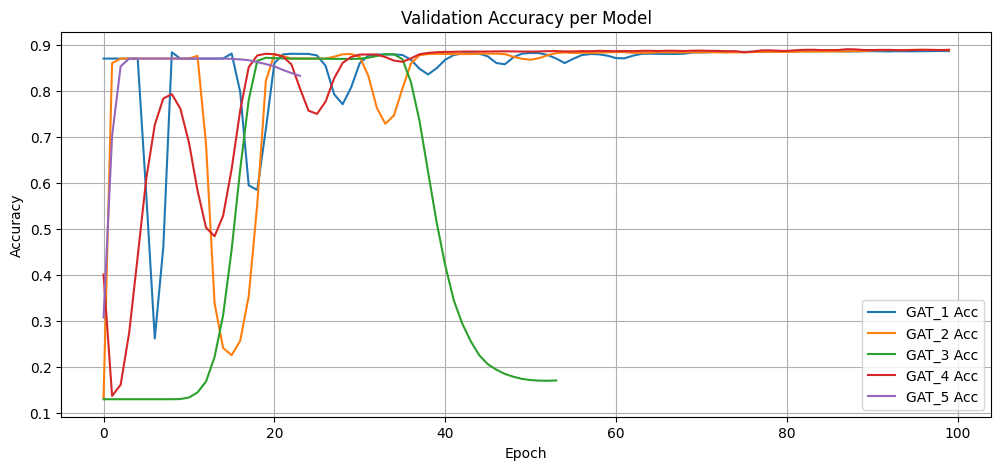

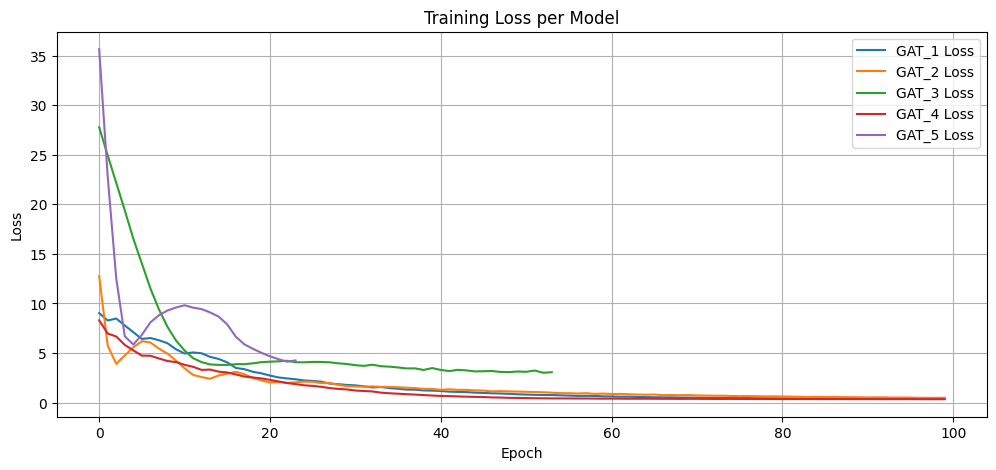

(GAT(
   (gat1): GATConv(16, 16, heads=4)
   (gat2): GATConv(64, 2, heads=1)
 ),
 [35.63837814331055,
  22.771289825439453,
  12.515029907226562,
  6.684020519256592,
  5.850112438201904,
  6.832452297210693,
  8.088349342346191,
  8.810103416442871,
  9.283369064331055,
  9.589884757995605,
  9.8125638961792,
  9.5726318359375,
  9.42020320892334,
  9.087217330932617,
  8.661160469055176,
  7.874227046966553,
  6.641866683959961,
  5.8711113929748535,
  5.420650482177734,
  5.017293930053711,
  4.660768508911133,
  4.374253749847412,
  4.123541355133057,
  4.249581813812256],
 [0.3079187817258883,
  0.7018274111675127,
  0.8530964467005077,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.869238578680203,
  0.8681218274111675,
  0.8663959390862944,
  0.8623350253807106,

In [21]:
gat_models_configs = {
    "GAT_1": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 8},
        "lr": 0.005,
        "epochs": 100,
        "early_stopping": False
    },
    "GAT_2": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 8},
        "lr": 0.005,
        "epochs": 100
    },
    "GAT_3": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 8},
        "lr": 0.001,
        "epochs": 100
    },
    "GAT_4": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 4},
        "lr": 0.005,
        "epochs": 100
    },
    "GAT_5": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 4, "dropout": 0.3},
        "lr": 0.007,
        "epochs": 100
    },
}

training_run(gat_models_configs)


Training sage1
sage1 Best Val Acc: 0.8870 | Test Acc: 0.8882

Training sage2
Early stopping at epoch 73
sage2 Best Val Acc: 0.8738 | Test Acc: 0.8725

Training sage3
Early stopping at epoch 43
sage3 Best Val Acc: 0.8733 | Test Acc: 0.8700

Training sage4
Early stopping at epoch 21
sage4 Best Val Acc: 0.8699 | Test Acc: 0.8698

Training sage5
Early stopping at epoch 71
sage5 Best Val Acc: 0.8766 | Test Acc: 0.8733

Training sage6
sage6 Best Val Acc: 0.8847 | Test Acc: 0.8856


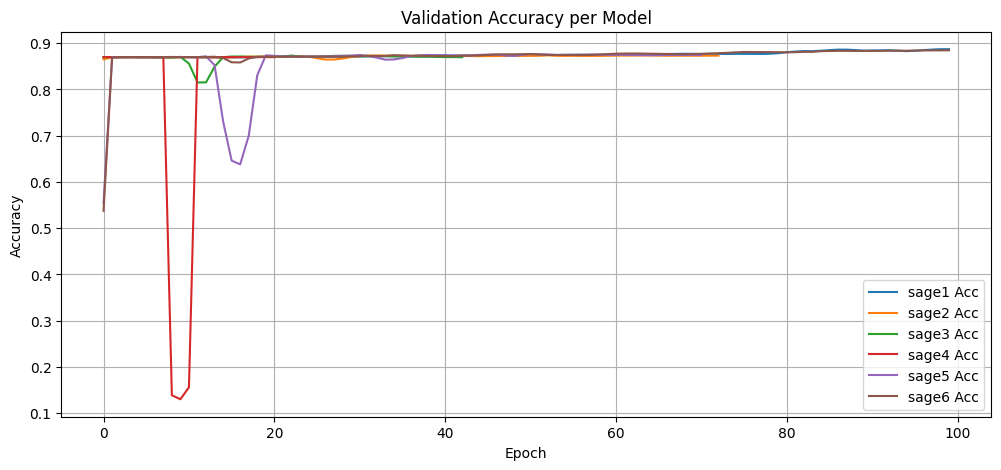

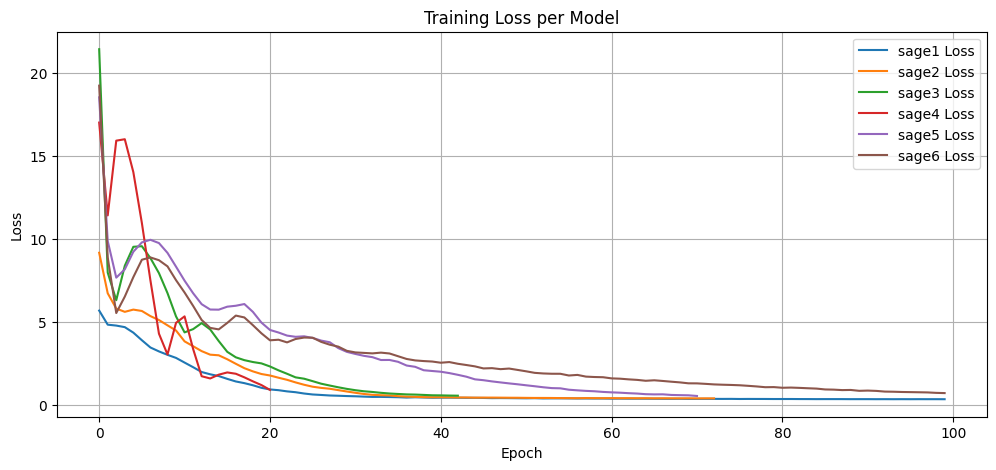

(GraphSAGE(
   (conv1): SAGEConv(16, 32, aggr=softmax)
   (conv2): SAGEConv(32, 2, aggr=softmax)
 ),
 [19.24681282043457,
  8.896706581115723,
  5.542027950286865,
  6.532279014587402,
  7.706740856170654,
  8.754725456237793,
  8.893628120422363,
  8.726017951965332,
  8.355538368225098,
  7.522850036621094,
  6.779463768005371,
  5.974091529846191,
  5.122591018676758,
  4.647304058074951,
  4.555676460266113,
  4.947981357574463,
  5.388948917388916,
  5.276369571685791,
  4.810769557952881,
  4.319769859313965,
  3.898489236831665,
  3.933793544769287,
  3.7731831073760986,
  3.9778506755828857,
  4.064815521240234,
  4.054771900177002,
  3.8031461238861084,
  3.634284257888794,
  3.5176031589508057,
  3.2638025283813477,
  3.1689770221710205,
  3.1396894454956055,
  3.1106836795806885,
  3.155552387237549,
  3.104243040084839,
  2.9390766620635986,
  2.774017572402954,
  2.687068462371826,
  2.647575855255127,
  2.619030237197876,
  2.5473263263702393,
  2.5871009826660156,
  2.48

In [22]:
sage_models_configs = {
    "sage1": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "mean", "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100,
        "early_stopping": False
    },
    "sage2": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "mean", "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100
    },
    "sage3": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "mean", "dropout": 0.5},
        "lr": 0.01,
        "epochs": 100
    },
    "sage4": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "mean", "dropout": 0.5},
        "lr": 0.02,
        "epochs": 100
    },
    "sage5": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "softmax", "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100
    },
    "sage6": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2, "aggr": "softmax", "dropout": 0.3},
        "lr": 0.005,
        "epochs": 100
    },
}

training_run(sage_models_configs)


Training cb1
cb1 Best Val Acc: 0.8793 | Test Acc: 0.8808

Training cb2
Early stopping at epoch 25
cb2 Best Val Acc: 0.8627 | Test Acc: 0.8593

Training cb3
Early stopping at epoch 32
cb3 Best Val Acc: 0.8741 | Test Acc: 0.8424

Training cb4
Early stopping at epoch 21
cb4 Best Val Acc: 0.8543 | Test Acc: 0.8421

Training cb5
Early stopping at epoch 30
cb5 Best Val Acc: 0.8690 | Test Acc: 0.8421

Training cb6
Early stopping at epoch 21
cb6 Best Val Acc: 0.8699 | Test Acc: 0.8699


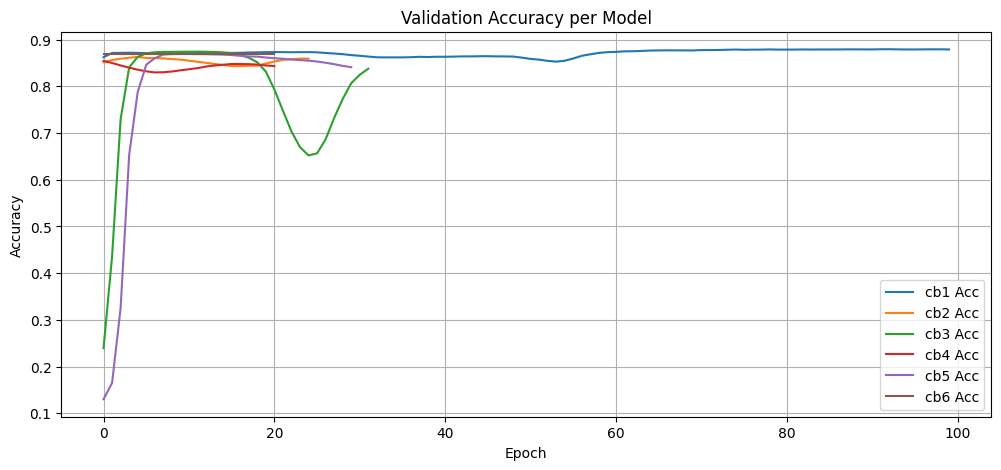

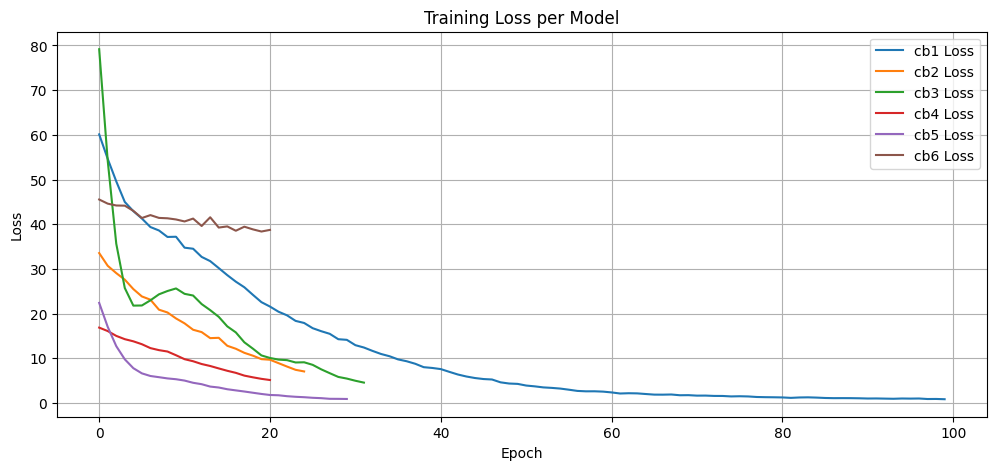

(ChebNet(
   (conv1): ChebConv(16, 16, K=2, normalization=sym)
   (conv2): ChebConv(16, 2, K=2, normalization=sym)
 ),
 [45.531856536865234,
  44.60617446899414,
  44.19172668457031,
  44.155029296875,
  42.992984771728516,
  41.390403747558594,
  42.04293441772461,
  41.41581344604492,
  41.328887939453125,
  41.0662956237793,
  40.62274169921875,
  41.26261901855469,
  39.60617446899414,
  41.55463790893555,
  39.25431442260742,
  39.51200866699219,
  38.542442321777344,
  39.44799041748047,
  38.85150146484375,
  38.36873245239258,
  38.73337936401367],
 [0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.8699492385786802,
  0.869949238578680

In [23]:
cb_models_configs = {
    "cb1": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 3, "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100,
        "early_stopping": False
    },
    "cb2": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 3, "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100
    },
    "cb3": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 3, "dropout": 0.5},
        "lr": 0.01,
        "epochs": 100
    },
    "cb4":{
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 2, "dropout": 0.5},
        "lr": 0.005,
        "epochs": 100
    },
    "cb5": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 2, "dropout": 0.5},
        "lr": 0.01,
        "epochs": 100
    },
    "cb6": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 2, "dropout": 0.5},
        "lr": 0.001,
        "epochs": 100
    },
}

training_run(cb_models_configs)

In [22]:
def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = softmax(out, dim=1)
        pred = probs.argmax(dim=1)
        return pred

In [24]:
def explain(data_npz, data, model, preds):
    # Load coordinates
    coordinates = data_npz["coordinates"]
    print(len(coordinates))
    assert len(coordinates) == data.x.shape[0], "Mismatch in coordinate and node count."

    feature_names = [
        'node_highway', 'street_count',
        'edge_highway', 'edge_length', 'edge_bridge', 'edge_lanes', 'edge_oneway',
        'edge_maxspeed', 'edge_access', 'edge_tunnel', 'edge_junction',
        'edge_dir_x', 'edge_dir_y',
        'angle_min', 'angle_max', 'angle_pi'
    ]

    # Padding if your final feature count exceeds 14
    if data.x.shape[1] > len(feature_names):
        feature_names += [f"feature_{i}" for i in range(len(feature_names), data.x.shape[1])]

    # GNNExplainer
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=30),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )

    # For each predicted hotspot, explain and output top features
    k = 5  # top-k features to show
    print(f"\n🔍 HOTSPOT ANALYSIS (Top {k} Features Per Hotspot Node):\n")
    for node_idx in range(data.num_nodes):
        if preds[node_idx] == 1:  # predicted hotspot
            explanation = explainer(data.x, data.edge_index, index=int(node_idx))
            feat_mask = explanation.node_mask[node_idx].cpu().detach().numpy()

            # Rank top-k features
            top_k = np.argsort(-feat_mask)[:k]
            feature_scores = [(feature_names[i], feat_mask[i]) for i in top_k]

            # Output
            lat, lon = coordinates[node_idx]
            print(f"📍 Node {node_idx} | Coordinates: ({lat:.6f}, {lon:.6f})")
            for name, score in feature_scores:
                print(f"   - {name}: {score:.4f}")
            print("-" * 50)


In [ ]:
# Explain


49251

🔍 HOTSPOT ANALYSIS (Top 5 Features Per Hotspot Node):



KeyError: 0

In [6]:
import pickle
from pathlib import Path

cities = fetch_cities()

outputs = {}
for city_name, filename in cities.items():
    # If city already exists, skip
    filepath = Path(f"../output/{city_name}/")
    if filepath.is_dir():
        # print(f"{city_name} folder exists")
        continue

    data, data_npz = load_dataset(filename)
    if data is None:
        continue
    gcn = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)
    gcn.setup()
    gcn.train_model(data)
    gcn.plot_loss_and_accuracy(city_name)
    preds = gcn.predict(data)
    outputs[city_name] = preds
    # explain(data_npz, data, gcn, preds)

    # Save the model
    os.makedirs(f"../output/{city_name}", exist_ok=True)
    torch.save(gcn.state_dict(), f"../output/{city_name}/model.pth")
    # Save the outputs
    with open(f"../output/{city_name}/outputs.pkl", "wb") as f:
        pickle.dump(outputs[city_name], f)




In [7]:
top_10_cities = [
  "new_york_ny",
  "oklahoma_city_ok", 
  "los_angeles_ca",
  "houston_tx",
  "new_york_ny",
  "phoenix_az",
  "san_antonio_tx",
  "dallas_tx",
  "jacksonville_fl",
  "indianapolis_in",
  "charlotte_nc"
]

In [ ]:
# TODO: Not implemented yet

#Top recurring features in hotspots
k = 5
feature_counter = Counter()

for node_idx in range(data.num_nodes):
    if preds[node_idx] == 1:  # Only for predicted hotspots
        explanation = explainer(data.x, data.edge_index, index=int(node_idx))
        feat_mask = explanation.node_mask[node_idx].cpu().detach().numpy()

        # Get top-k important feature indices
        top_k_indices = np.argsort(-feat_mask)[:k]

        # Add feature names to counter
        feature_counter.update([feature_names[i] for i in top_k_indices])

# Sort and display most frequent top features
most_common_features = feature_counter.most_common(10)
print("\nMost Common Top Features for Hotspot Predictions:")
for name, freq in most_common_features:
    print(f"{name}: {freq} times in top-{k}")


In [8]:
def hotspot_heatmap(coordinates, preds, city_name):
  # Don't generate if heatmap already exists
  if Path(f"../output/{city_name}/hotspot_heatmap.png").is_file():
    return
  #Hotspot heatmap
  hotspot_coords = coordinates[preds == 1]
  non_hotspot_coords = coordinates[preds == 0]

  plt.figure(figsize=(10, 8))
  plt.scatter(non_hotspot_coords[:, 1], non_hotspot_coords[:, 0],
              c='skyblue', s=10, label='Non-Hotspots', alpha=0.5)
  plt.scatter(hotspot_coords[:, 1], hotspot_coords[:, 0],
              c='red', s=20, label='Hotspots', alpha=0.8)

  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.title("Hotspot Prediction Map")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"../output/{city_name}/hotspot_heatmap.png")

In [9]:
def generate_hotspot_geojson(coordinates, preds, city_name):
    # Generate geojson
    geojson = {
        "type": "FeatureCollection",
        "features": []
    }
    for i, (lat, lon) in enumerate(coordinates):
        if preds[i] == 1:
            feature = {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [lon, lat]
                },
                "properties": {
                    "name": f"{city_name} hotspot {i}"
                }
            }
            geojson["features"].append(feature)
    return geojson

In [ ]:
import json

cities = fetch_cities()

# Load the model and outputs
for city_name in cities.keys():
    if not Path(f"../output/{city_name}").is_dir():
        continue
    # If city geojson already exists, skip
    if Path(f"../output/{city_name}/hotspot_geojson.json").is_file():
        continue

    # print(f"Fetching heatmap for {city_name}")
    data, data_npz = load_dataset(city_name)

    model = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)
    model.load_state_dict(torch.load(f"../output/{city_name}/model.pth"))

    with open(f"../output/{city_name}/outputs.pkl", "rb") as file:
        outputs = pickle.load(file)
        hotspot_heatmap(data_npz["coordinates"], outputs, city_name)
        try:
            geojson = generate_hotspot_geojson(data_npz["coordinates"], outputs, city_name)
            # If file exists, delete it
            if Path(f"../output/{city_name}/hotspot_geojson.json").is_file():
                os.remove(f"../output/{city_name}/hotspot_geojson.json")
            with open(f"../output/{city_name}/hotspot_geojson.json", "w") as f:
                json.dump(geojson, f)
        except Exception as e:
            print(f"Error generating geojson for {city_name}: {e}")

In [11]:
# Compile a geojson file with the top 10 cities
top_10_cities_geojson = {
    "type": "FeatureCollection",
    "features": []
}

for city_name in top_10_cities:
    with open(f"../output/{city_name}/hotspot_geojson.json", "r") as f:
        geojson = json.load(f)
        top_10_cities_geojson["features"].extend(geojson["features"])

with open("../output/top_10_cities_geojson.json", "w") as f:
    json.dump(top_10_cities_geojson, f)

In [12]:
# With the top 10 cities geojson file, create a map with folium
import folium

# Create a map centered on the first city's coordinates
map = folium.Map(location=[top_10_cities_geojson["features"][0]["geometry"]["coordinates"][1], top_10_cities_geojson["features"][0]["geometry"]["coordinates"][0]], zoom_start=12)

# Add the top 10 cities geojson to the map
folium.GeoJson(top_10_cities_geojson).add_to(map)

# Save the map to an html file
map.save("../output/top_10_cities_map.html")
